# **Hand Gesture Recognition Using CNN**:

To build a machine learning model that classifies hand gestures from grayscale images using Convolutional Neural Networks (CNNs). These gestures can be used for applications like human-computer interaction, sign language interpretation, and gesture-controlled interfaces.

The final system can be extended for real-time gesture detection using webcam input, making it a foundation for more interactive and intelligent systems.

In [14]:
!pip install opencv-python tensorflow

In [15]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"zahadanahaneeft","key":"cc6c7786f223bb084c5c19aef75e4330"}'}

In [16]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [17]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
leapgestrecog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
import zipfile
import os

zip_path = "/content/leapgestrecog.zip"  # replace with your actual file name
extract_path = "/content/hand_gesture_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [19]:
import os
for root, dirs, files in os.walk("/content/hand_gesture_data"):
    for name in files:
        if name.endswith(".png"):
            print(os.path.join(root, name))
            break  # print only one example


/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/09_c/frame_06_09_0090.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/04_fist_moved/frame_06_04_0141.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/05_thumb/frame_06_05_0016.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/10_down/frame_06_10_0143.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/06_index/frame_06_06_0153.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/08_palm_moved/frame_06_08_0076.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/07_ok/frame_06_07_0003.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/03_fist/frame_06_03_0110.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/02_l/frame_06_02_0141.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/06/01_palm/frame_06_01_0078.png
/content/hand_gesture_data/leapgestrecog/leapGestRecog/03/09_c/frame_03_09_0049.png
/content/hand_gesture_data/leapgestrecog

In [20]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = "/content/hand_gesture_data/leapGestRecog"
image_size =(64,64)

In [21]:
X=[]
y=[]

gesture_names = {}
label_number=0

# Looping through folders

for folder_name in sorted(os.listdir(data_dir)):
    folder_path = os.path.join(data_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    for gesture_folder in sorted(os.listdir(folder_path)):
        gesture_folder_path = os.path.join(folder_path, gesture_folder)
        if not os.path.isdir(gesture_folder_path):
            continue

        gesture = gesture_folder[3:]
        if gesture not in gesture_names:
           gesture_names[gesture]= label_number
           label_number += 1

        label= gesture_names[gesture]


        # Looping through all images in gesture files.
        for image_file in os.listdir(gesture_folder_path):
          image_path = os.path.join(gesture_folder_path, image_file)

          # Read and process image
          image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
          if image is None:
             continue
          image = cv2.resize(image, image_size)

          X.append(image)
          y.append(label)

# Convert to numpy arrays

X=np.array(X)
y=np.array(y)

# Normalize (pixel values between 0 and 1) and reshape
X = X / 255.0
X = X.reshape(-1, 64, 64, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Images loaded:", len(X))
print("Gestures found:", gesture_names)
print("X_train shape:", X_train.shape)

Images loaded: 20000
Gestures found: {'palm': 0, 'l': 1, 'fist': 2, 'fist_moved': 3, 'thumb': 4, 'index': 5, 'ok': 6, 'palm_moved': 7, 'c': 8, 'down': 9}
X_train shape: (16000, 64, 64, 1)


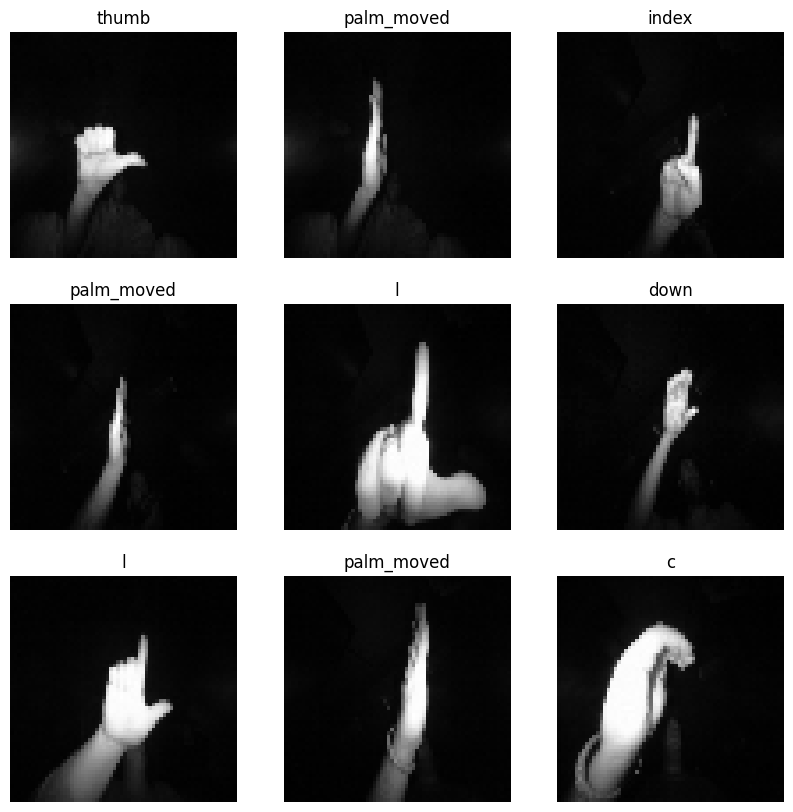

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    index= np.random.randint(0, len(X_train))
    image = X_train[index].reshape(64, 64)
    label = y_train[index]

    # finding gesture name from label
    for gesture, label_value in gesture_names.items():
        if label_value == label:
            gesture_name = gesture
            break

    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(gesture_name)
    plt.axis('off')
plt.show()

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Creating the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(gesture_names), activation='softmax')
    ])

# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6547 - loss: 0.9848 - val_accuracy: 0.9952 - val_loss: 0.0180
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9776 - loss: 0.0702 - val_accuracy: 0.9987 - val_loss: 0.0086
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9864 - loss: 0.0416 - val_accuracy: 0.9992 - val_loss: 0.0046
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9911 - loss: 0.0284 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9915 - loss: 0.0240 - val_accuracy: 0.9998 - val_loss: 0.0019
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9934 - loss: 0.0209 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9930 - loss: 0.0224 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9943 - loss: 0.0166 - val_accuracy: 0.

In [24]:
model.save("hand_gesture_model.h5")

In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt


gesture_names = {
    0: '01_palm',
    1: '02_l',
    2: '03_fist',
    3: '04_fist_moved',
    4: '05_thumb',
    5: '06_index',
    6: '07_ok',
    7: '08_palm_moved',
    8: '09_c',
    9: '10_down'
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


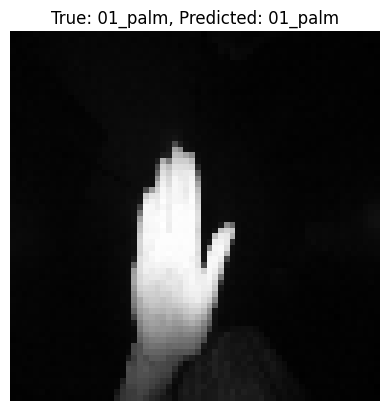

In [33]:
random_index = random.randint(0, len(X_test) - 1)


random_image = X_test[random_index]
true_label = np.argmax(y_test[random_index])


input_image = np.reshape(random_image, (1, 64, 64, 1))


prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)


plt.imshow(random_image.squeeze(), cmap='gray')
plt.title(f"True: {gesture_names[true_label]}, Predicted: {gesture_names[predicted_label]}")
plt.axis('off')
plt.show()


# **Conclusion**:
This project successfully demonstrates the application of Convolutional Neural Networks (CNNs) for recognizing static hand gestures from grayscale images with high accuracy. By leveraging the LEAP GestRecog dataset and a well-structured CNN model, the system achieved near-perfect test accuracy (100%), proving its effectiveness in distinguishing between 10 distinct hand gesture classes.

**Future improvements could include** :

* Real-time gesture recognition using webcam input

* Dynamic gesture detection using video frames or temporal models (RNNs/LSTMs)

* Deployment on mobile or embedded systems


In conclusion, the project demonstrates that deep learning offers a powerful and scalable approach to hand gesture recognition, opening doors for applications in human-computer interaction, sign language translation, and gesture-based controls.